# Import necessary Python libraries and set up the environment

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager
import matplotlib as mpl
import seaborn as sns
import networkx as nx
from collections import Counter
from adjustText import adjust_text

from scipy.stats import entropy
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
!rm -rf ~/.cache/matplotlib/*

plt.rc('font', family='Arial')
mpl.rcParams['axes.unicode_minus'] = False

In [4]:
#!python network_evaluation.py

In [62]:
#!python sensitivity_analysis.py

Figure(800x600)
Figure(800x600)
Figure(800x600)


## Load dataset from local CSV file

In [7]:
df_course = pd.read_csv('df_course.csv')
df_skill = pd.read_csv('df_skill.csv')
df_job = pd.read_csv('df_job.csv')

course_skill_matrix_df = pd.read_csv('/home/lhch9550/new_course_skill_matrix.csv')
course_skill_matrix_df.set_index('id', inplace=True)

In [8]:
course_skill_matrix_df

,ACC-AUD-4003-1.1,ACC-AUD-4001-1.1,ACC-PVE-3001-1.1,ACC-AUD-4004-1.1,ACC-AUD-4005-1.1,ACC-AUD-4006-1.1,ACC-AUD-4007-1.1,ACC-AUD-4008-1.1,ACC-MAC-3001-1.1,ACC-IAD-3001-1.1,...,WPH-QUA-5021-1.1,WPH-TEM-3017-1.1,WPH-TEM-3011-1.1,WPH-WSH-2079-1.1,WPH-WSH-2080-1.1,WPH-WSH-2081-1.1,WPH-WSH-2082-1.1,WPH-WSH-2083-1.1,WPH-WSH-1084-1.1,WPH-WSH-2085-1.1
id,,,,,,,,,,,,,,,,,,,,,
Microsoft Excel 2013 Pivot Table Proficiency,0.181480,0.187170,0.083004,0.207580,0.117338,0.167010,0.096290,0.121655,0.248722,0.223078,...,0.138413,0.097097,0.209821,0.138664,0.109768,0.134733,0.127469,0.146832,0.054926,0.078062
Air-Conditioning - Basic Maintenance for Home Split Unit,0.161878,0.148460,0.131997,0.122029,0.205305,0.036493,0.155991,0.095671,0.078447,0.187625,...,0.173905,0.080504,0.206995,0.315988,0.285416,0.328739,0.234313,0.318967,0.225687,0.206677
Certificate in Athlete Life Coaching,0.251671,0.326717,0.109453,0.348112,0.299361,0.250076,0.242755,0.236788,0.161152,0.194219,...,0.062562,0.006293,0.117493,0.166548,0.098454,0.122237,0.098785,0.152214,0.212942,0.077294
Certificate Course in 2nd Grade Computer Aided Drafting (For Steam Engineers),0.054930,0.119332,-0.016256,0.181255,0.160762,0.184661,0.122493,0.047538,-0.012992,0.070863,...,0.068388,0.053957,0.178439,0.108953,0.136365,0.137614,0.082798,0.072413,0.113518,0.143892
Certificate Course in 2nd Grade Mechanics II (For Steam Engineers),0.058651,0.064089,-0.023753,0.023501,0.051501,-0.043339,0.009543,-0.019365,0.030119,0.052614,...,0.041003,0.037123,0.125917,0.072487,0.110095,0.173598,0.102159,0.157383,0.097563,0.164849
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"""Think Out Of The Box"" (Synchronous e-Learning)",0.149470,0.245527,0.192913,0.317480,0.223300,0.253468,0.238294,0.222715,0.298581,0.368722,...,0.186928,0.192404,0.268968,0.224981,0.221908,0.246847,0.209325,0.259130,0.227612,0.211194
EC-Council Certified Ethical Hacker (Synchronous e-learning),0.268546,0.258658,0.219989,0.142315,0.303066,0.074214,0.266546,0.133662,0.043070,0.132668,...,0.209013,0.265583,0.189280,0.202823,0.162219,0.180533,0.199249,0.200656,0.291600,0.224958
Family Mediation Certification Programme (Module 1) Family Law,0.297021,0.315129,0.185760,0.303956,0.305438,0.159646,0.284462,0.241612,0.016854,0.108825,...,0.082821,0.027919,0.023525,0.176446,0.175780,0.160416,0.135470,0.166757,0.210584,0.123985


## Filtering, Visualizing, and Analyzing Course-Skill Matrix

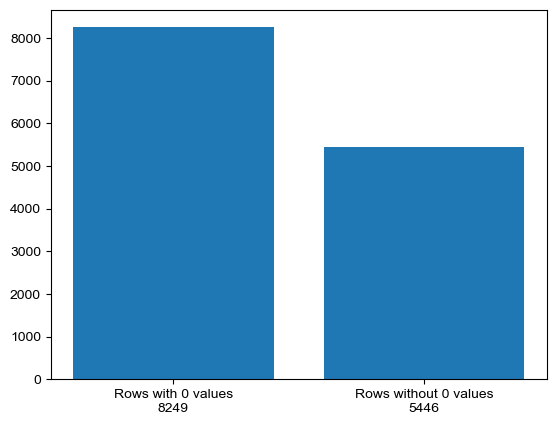

In [9]:
course_skill_matrix = course_skill_matrix_df.values
course_skill_matrix.shape

threshold = 0.6

filtered_matrix = np.where(course_skill_matrix < threshold, 0, course_skill_matrix)

# Replace non-zero values with 1
filtered_matrix[filtered_matrix != 0] = 1

# Count rows with at least one "1"
row_counts = np.sum(filtered_matrix, axis=1) > 0
rows_with_ones = np.sum(row_counts)

# Calculate the number of rows with 0 and 1
rows_with_zeros = filtered_matrix.shape[0] - rows_with_ones

# Create a bar chart to visualize the comparison
labels = ['Rows with 0 values\n{}'.format(rows_with_zeros), 'Rows without 0 values\n{}'.format(rows_with_ones)]
values = [rows_with_zeros, rows_with_ones]

plt.bar(labels, values)
plt.show()

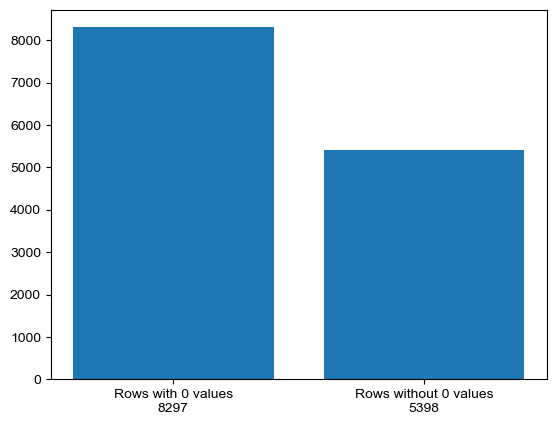

In [10]:
# Transpose the matrix
transposed_matrix = np.transpose(filtered_matrix)

# Perform matrix multiplication
monopartite_matrix = np.dot(filtered_matrix, transposed_matrix)
monopartite_matrix[np.diag_indices_from(monopartite_matrix)] = 0

# Count rows with at least one "1"
row_counts = np.sum(monopartite_matrix, axis=1) > 0
rows_with_ones = np.sum(row_counts)

# Calculate the number of rows with 0 and 1
rows_with_zeros = monopartite_matrix.shape[0] - rows_with_ones

# Create a bar chart to visualize the comparison
labels = ['Rows with 0 values\n{}'.format(rows_with_zeros), 'Rows without 0 values\n{}'.format(rows_with_ones)]
values = [rows_with_zeros, rows_with_ones]

plt.bar(labels, values)
plt.show()

# Constructing a Course Network and Calculating Course Coverage

In [11]:
#Construct Course network using monopartite_matrix
G = nx.Graph()
n = monopartite_matrix.shape[0]

for i in range(n):
    for j in range(i + 1, n):
        weight = float(monopartite_matrix[i][j])  
        if weight > 0:
          G.add_edge(i, j, weight=weight)

In [12]:
#add course name attributes to each node
node_names = course_skill_matrix_df.index
node_indices = np.arange(filtered_matrix.shape[0])
node_index_to_name = {index: name for index, name in zip(node_indices, node_names)}
for node in G.nodes:
    G.nodes[node]['name'] = node_index_to_name[node]

In [13]:
#extract id(course name) and label from course dataframe
df_course_columns = ['id', 'course_label']
#by matching with the names(ids) of each node, assign labels to each node
for node in G.nodes():
    node_name = G.nodes[node]['name']
    corresponding_row = df_course[df_course['id'] == node_name]
    if not corresponding_row.empty:
        label_value = corresponding_row.iloc[0][df_course_columns[1]]
        G.nodes[node]['label'] = label_value
    else:
        G.nodes[node]['label'] = 'Unknown'

In [14]:
#Calculate course_coverage for each node and assign
row_sums = np.sum(filtered_matrix, axis=1)
course_index = course_skill_matrix_df.index
course_coverage_df = pd.DataFrame(data={'row_sum': row_sums}, index=course_index)

# Iterate through the nodes in the graph and update the 'row_sum' attribute
for node in G.nodes():
    node_name = G.nodes[node]['name']
    if node_name in course_coverage_df.index:
        G.nodes[node]['course_coverage'] = course_coverage_df.loc[node_name, 'row_sum']

In [15]:
# Compute the degree (number of connections) for each node in the graph G
degrees = dict(G.degree())

# Find the maximum degree in the entire network
max_degree = max(degrees.values())
print("Max Degree:", max_degree)

# Identify the top 10% of nodes with the highest degree
n_nodes = len(degrees)
n_top = max(1, int(n_nodes * 0.1))  # Ensure at least one node is included
top_nodes = sorted(degrees.items(), key=lambda x: x[1], reverse=True)[:n_top]

# Calculate the average degree among the top 10% nodes
avg_top_degree = sum(deg for _, deg in top_nodes) / n_top
print(f"Average Degree of Top 10% Nodes: {avg_top_degree:.2f}")

# Retrieve 'label' attributes for the top nodes (default to 'Unknown' if not present)
labels = [G.nodes[node].get('label', 'Unknown') for node, _ in top_nodes]

# Count how often each label appears among the top nodes
label_counts = Counter(labels)

# Store the total number of top nodes for later ratio calculation
total_top = len(top_nodes)

# Identify the 10 most common labels among the top nodes
top_10_labels = label_counts.most_common(10)

# Display the results: label, count, and proportion among top 10% nodes
print("Top 10 Most Common Labels in the Top 10% Nodes:")
for label, count in top_10_labels:
    ratio = count / total_top * 100
    print(f"Label: {label}, Count: {count}, Ratio: {ratio:.2f}%")


Max Degree: 538
Average Degree of Top 10% Nodes: 309.72
Top 10 Most Common Labels in the Top 10% Nodes:
Label: Workplace Safety and Health, Count: 156, Ratio: 28.94%
Label: Leadership & People Management, Count: 52, Ratio: 9.65%
Label: Human Resource Management, Employment and Recruitment, Count: 44, Ratio: 8.16%
Label: Information and Communications, Count: 37, Ratio: 6.86%
Label: Business Management, Count: 32, Ratio: 5.94%
Label: Education and Training, Count: 30, Ratio: 5.57%
Label: Food and Beverages, Count: 23, Ratio: 4.27%
Label: Environmental Cleaning, Count: 20, Ratio: 3.71%
Label: Advertising, Sales & Marketing, Count: 18, Ratio: 3.34%
Label: Productivity and Innovation, Count: 18, Ratio: 3.34%


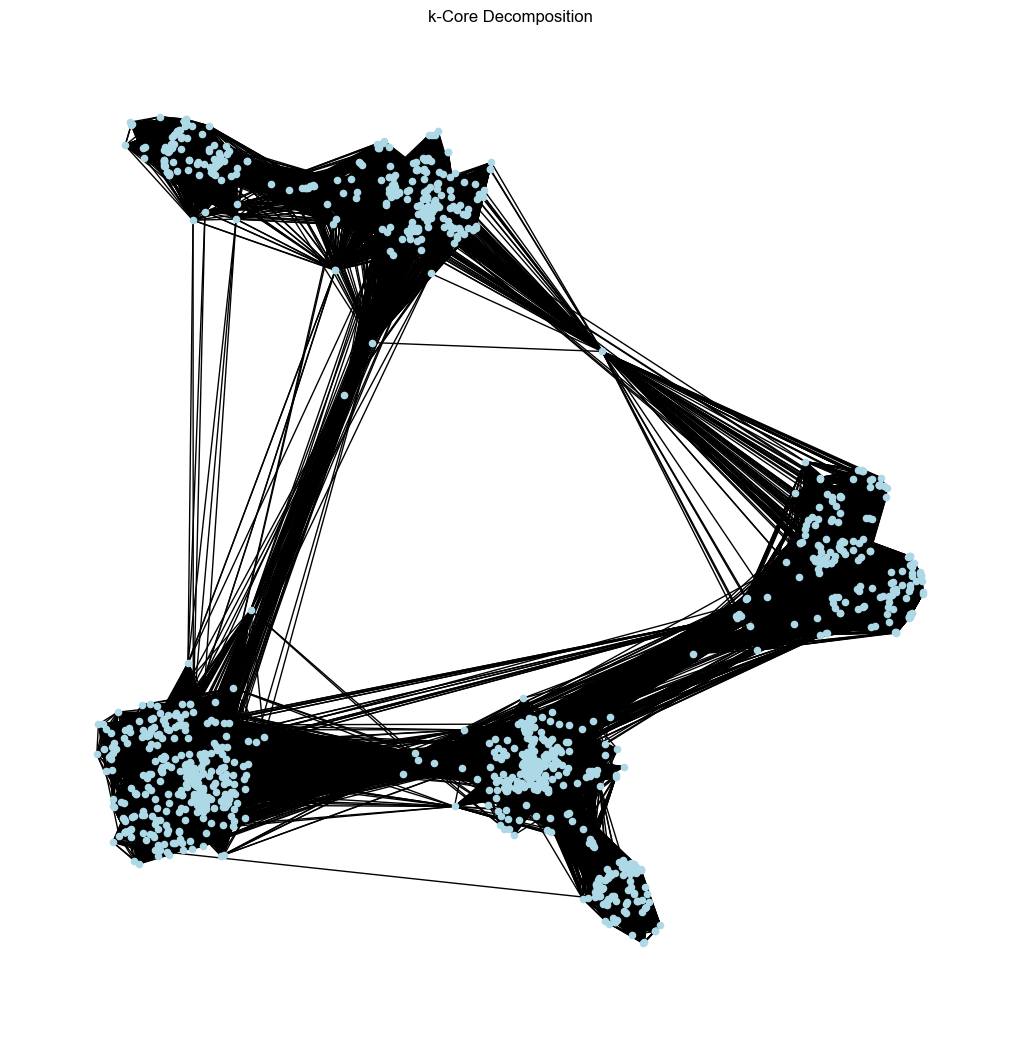

In [16]:
# Get the k-core decomposition of the graph
k_cores = nx.k_core(G, 100)

# Visualize the k-cores
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(k_cores)  # You can choose a layout algorithm as per your preference
nx.draw(k_cores, pos, node_color='lightblue', node_size=20)
plt.title('k-Core Decomposition')
plt.show()

# Constructing a Bipartite Network and Calculating Course Specificity

In [17]:
#To calcualte course specificity, start with making a bipartite network of course-job/skill
B = nx.Graph()

course_names = course_skill_matrix_df.index
skill_names = course_skill_matrix_df.columns

B.add_nodes_from(course_names, bipartite=0) 
B.add_nodes_from(skill_names, bipartite=1)   

for i in range(len(course_names)):
    course_name = course_names[i]
    for j in range(len(skill_names)):
        value = filtered_matrix[i, j]
        if value == 1:
            skill_name = skill_names[j]
            B.add_edge(course_name, skill_name)

In [18]:
#assign labels to each node in B
labels_course = {node: row['course_label'] for node, row in df_course.set_index('id').iterrows()}
labels_skill = {node: row['skill_label'] for node, row in df_skill.set_index('id').iterrows()}
labels_job = {node: row['job_label'] for node, row in df_job.set_index('id').iterrows()}

for node in B.nodes():
    if B.nodes[node]['bipartite'] == 0:
        B.nodes[node]['course_label'] = labels_course.get(node)
    elif B.nodes[node]['bipartite'] == 1:
        B.nodes[node]['skill_label'] = labels_skill.get(node) or labels_job.get(node)

In [19]:
# Calculate kc0 and kpo values from the edge_list
edge_list = nx.to_pandas_edgelist(B)
kc0 = edge_list.groupby('source')['target'].count().reset_index()
kp0 = edge_list.groupby('target')['source'].count().reset_index()

#Save kc0 in source nodes as 'kc0' attributes
for node, kc0_value in zip(kc0['source'], kc0['target']):
    if node in B.nodes:
        B.nodes[node]['kc0'] = kc0_value

#Save kp0 in target nodes as 'kp0' attributes
for node, kp0_value in zip(kp0['target'], kp0['source']):
    if node in B.nodes:
        B.nodes[node]['kp0'] = kp0_value

In [20]:
# Loop for calculating kc1 to kc2
for iteration in range(1, 3):  # Assuming you want to calculate up to kc2

    # Calculate kc_i for each source node
    for source_node in B.nodes:
        neighbors = list(B.neighbors(source_node))

        # Sum kp(i-1) attributes of neighbors that have 'kp(i-1)' values
        kp_sum = sum(B.nodes[neighbor]['kp{}'.format(iteration-1)] for neighbor in neighbors
                     if 'kp{}'.format(iteration-1) in B.nodes[neighbor])

        # Divide the sum of kp0 attribute by inverse of kc0 of the source node
        if 'kc0' in B.nodes[source_node]:
            kc0_value = B.nodes[source_node]['kc0']
            B.nodes[source_node]['kc{}'.format(iteration)] = kp_sum / kc0_value

    # Calculate kp_i for each target node
    for target_node in B.nodes:
        source_node_neighbors = list(B.neighbors(target_node))

        # Sum kc(i) attributes of source node neighbors
        kc_sum = sum(B.nodes[source]['kc{}'.format(iteration-1)] for source in source_node_neighbors
                    if 'kc{}'.format(iteration-1) in B.nodes[source])

        # Divide the sum of kc(i) attribute by kpo of the target node
        if 'kp0' in B.nodes[target_node]:
            kp0_value = B.nodes[target_node]['kp0']
            B.nodes[target_node]['kp{}'.format(iteration)] = kc_sum / kp0_value

In [21]:
# Extract data from source nodes
source_data = {'Node': []}
for i in range(3):  # Assuming you want kc0 to kc10
    source_data[f'kc{i}'] = []

for node in B.nodes:
    source_data['Node'].append(node)
    for i in range(3):
        attribute_key = f'kc{i}'
        source_data[attribute_key].append(B.nodes[node].get(attribute_key, np.nan))

# Create a dataframe from the extracted data
kc_df = pd.DataFrame(source_data)
kc_df = kc_df.dropna()
kc_df

,Node,kc0,kc1,kc2
2,Certificate in Athlete Life Coaching,2.0,42.000000,8.450147
3,Certificate Course in 2nd Grade Computer Aided...,7.0,33.428571,6.850874
7,Certificate Course in 2nd Grade Engineering Ma...,1.0,3.000000,1.333333
9,Certificate Course in 1st Grade Engineering Ma...,2.0,3.500000,1.416667
11,Joint ITE-UPEC Certificate in Pre-Hospital Eme...,2.0,37.000000,2.956938
...,...,...,...,...
13684,Fundamentals of Computer Programming (Synchron...,8.0,7.750000,9.118056
13685,Good Dispensing Practice (part of PDC2 of Adva...,1.0,4.000000,2.750000
13689,Audit Management I,3.0,19.666667,19.605797
13690,"""Think Out Of The Box"" (Synchronous e-Learning)",1.0,22.000000,12.318182


# Analyzing Course Influence and Specificity in VET Sectors

In [22]:
# create dataframe by extract course_name, coverage, label and degree of each node from the course network
course_influence = []
for node in G.nodes():
    node_data = {
        'Node': G.nodes[node]['name'],
        'coverage': G.nodes[node]['course_coverage'],
        'label':G.nodes[node]['label'],
        'degree': G.degree(node)}  
    course_influence.append(node_data)

# Create a dataframe
course_influence_df = pd.DataFrame(course_influence)
course_influence_df['course_influence'] = course_influence_df['coverage'] / course_influence_df['degree']
course_influence_df

,Node,coverage,label,degree,course_influence
0,Certificate in Athlete Life Coaching,2.0,Sports,80,0.025000
1,Continuous Improvement Management,14.0,Productivity and Innovation,282,0.049645
2,Design Transformative Learning and Development...,14.0,MICE & Events,284,0.049296
3,People Development (Level 5),23.0,Leadership & People Management,402,0.057214
4,Develop and Evaluate Strategies for Learning a...,23.0,"Human Resource Management, Employment and Recr...",345,0.066667
...,...,...,...,...,...
5393,"Chemistry, Manufacturing and Controls (Synchro...",1.0,Healthcare,1,1.000000
5394,"Selection, Installation and Safe Use of Biosaf...",1.0,Healthcare,2,0.500000
5395,Working with Families (In-Service Staff),1.0,Healthcare,1,1.000000
5396,Working with Families (New Hire),1.0,Healthcare,1,1.000000


In [23]:
#To compare impact and ubiquity, merge the two dataframes
merged_df = pd.merge(kc_df, course_influence_df, on='Node', how='left')
merged_df = merged_df.dropna().reset_index()
merged_df = merged_df.drop(columns=['index'])
merged_df

,Node,kc0,kc1,kc2,coverage,label,degree,course_influence
0,Certificate in Athlete Life Coaching,2.0,42.000000,8.450147,2.0,Sports,80.0,0.025000
1,Certificate Course in 2nd Grade Computer Aided...,7.0,33.428571,6.850874,7.0,Engineering,81.0,0.086420
2,Certificate Course in 2nd Grade Engineering Ma...,1.0,3.000000,1.333333,1.0,Engineering,2.0,0.500000
3,Certificate Course in 1st Grade Engineering Ma...,2.0,3.500000,1.416667,2.0,Engineering,5.0,0.400000
4,Joint ITE-UPEC Certificate in Pre-Hospital Eme...,2.0,37.000000,2.956938,2.0,Healthcare,56.0,0.035714
...,...,...,...,...,...,...,...,...
5393,Fundamentals of Computer Programming (Synchron...,8.0,7.750000,9.118056,8.0,Information and Communications,31.0,0.258065
5394,Good Dispensing Practice (part of PDC2 of Adva...,1.0,4.000000,2.750000,1.0,Pharmaceutical and Biotechnology,3.0,0.333333
5395,Audit Management I,3.0,19.666667,19.605797,3.0,Healthcare,34.0,0.088235
5396,"""Think Out Of The Box"" (Synchronous e-Learning)",1.0,22.000000,12.318182,1.0,Productivity and Innovation,21.0,0.047619


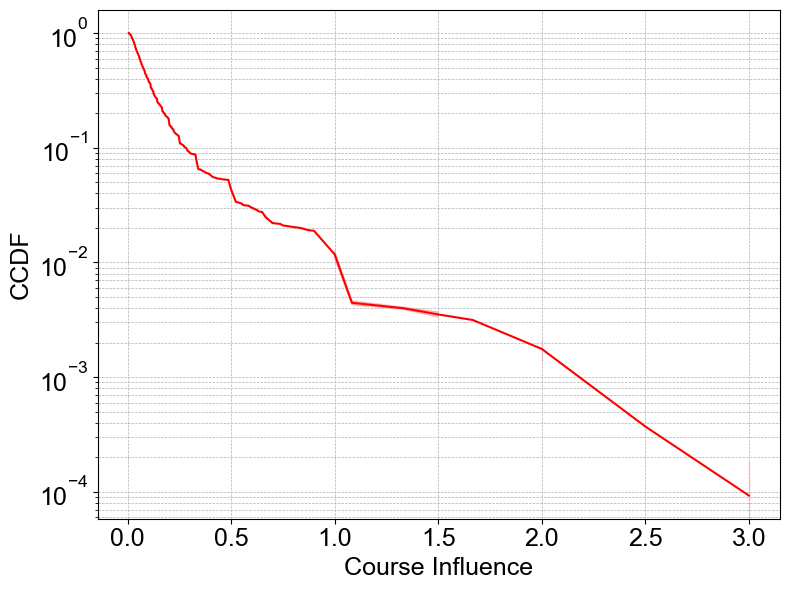

In [24]:
# Convert 'course_influence' column to a NumPy array
course_influence_array = merged_df['course_influence'].values
course_influence_array = np.array(course_influence_array)

# Sort the values in ascending order
sorted_values = np.sort(course_influence_array)

# Calculate the complementary cumulative distribution function (CCDF)
ccdf = 1 - np.arange(1, len(sorted_values) + 1) / len(sorted_values)

# Plot CCDF
plt.figure(figsize=(8, 6))
sns.lineplot(x=sorted_values, y=ccdf, color="red")

plt.xlabel('Course Influence', fontsize=18)
plt.ylabel('CCDF', fontsize=18)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.yscale("log")

plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()

# Save the figure with 300 dpi resolution
plt.savefig("ccdf_course_influence.png", dpi=300)
plt.show()

Looks like you are using an old matplotlib version.
               In some cases adjust_text might fail, if possible update
               matplotlib to version >=3.5.0


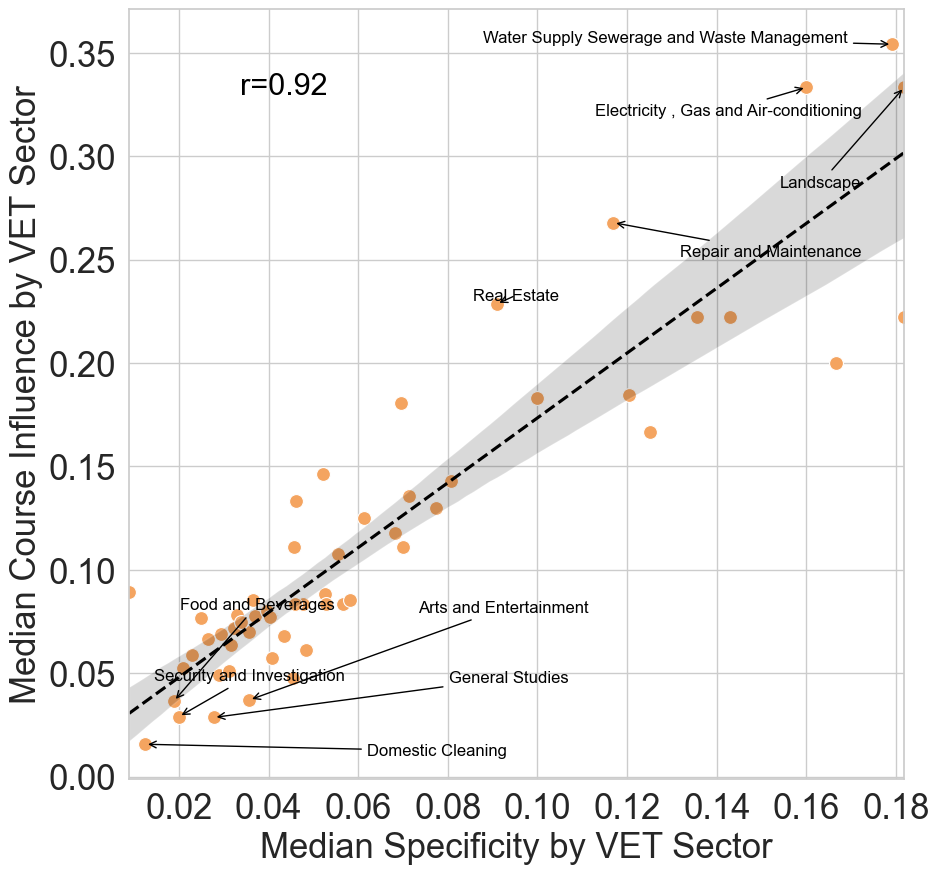

In [63]:
# Group by label and calculate median values
sector_df = merged_df.groupby('label')[['kc0', 'kc1', 'kc2', 'course_influence']].median().reset_index()

# Count the number of courses in each group
course_counts = merged_df['label'].value_counts().reset_index()
course_counts.columns = ['label', 'course_count']

# Merge the median_kc DataFrame with course_counts
sector_df = pd.merge(sector_df, course_counts, on='label')

# Filter out groups with counts under 50
sector_df_filtered = sector_df[sector_df['course_count'] >= 1]
sector_df_filtered = sector_df_filtered.drop('course_count', axis=1)

# Calculate the inverse of kc1
sector_df_filtered['specificity'] = 1 / sector_df_filtered['kc1']

# Sort by course_influence to get top and bottom 5 sectors
top_5 = sector_df_filtered.nlargest(5, 'course_influence')
bottom_5 = sector_df_filtered.nsmallest(5, 'course_influence')

# Create a scatter plot
plt.figure(figsize=(10, 10))
sns.scatterplot(x='specificity', y='course_influence', data=sector_df_filtered, color='sandybrown', s=100)

# Draw a fitted line (regression line)
sns.regplot(x='specificity', y='course_influence', data=sector_df_filtered, scatter=False, 
            line_kws={'linestyle': '--', 'color': 'black'})

# Calculate the correlation coefficient
correlation_coefficient_inverse_kc1 = sector_df_filtered['specificity'].corr(sector_df_filtered['course_influence'])

# Annotate top 5 and bottom 5 points with arrows
texts = []
for label, x, y in zip(top_5['label'], top_5['specificity'], top_5['course_influence']):
    if label == "General Studies":
        xytext_x, xytext_y = x + 0.03, y + 0.02  # General Studies → 오른쪽으로 더 이동
    elif label == "Real Estate":
        xytext_x, xytext_y = x + 0.02, y + 0.02  # Real Estate → 오른쪽으로 살짝 이동
    else:
        xytext_x, xytext_y = x + 0.02, y + 0.02  # 기본값
    
    texts.append(plt.annotate(label, (x, y), xytext=(xytext_x, xytext_y), 
                              fontsize=12, ha='left', va='bottom', color='black',
                              arrowprops=dict(arrowstyle="->", color='black', lw=1)))

for label, x, y in zip(bottom_5['label'], bottom_5['specificity'], bottom_5['course_influence']):
    if label == "Repair and Maintenance":
        xytext_x, xytext_y = x - 0.03, y - 0.02  # Repair and Maintenance → 왼쪽으로 살짝 이동
    else:
        xytext_x, xytext_y = x - 0.02, y - 0.02  # 기본값
    
    texts.append(plt.annotate(label, (x, y), xytext=(xytext_x, xytext_y), 
                              fontsize=12, ha='right', va='top', color='black',
                              arrowprops=dict(arrowstyle="->", color='black', lw=1)))

adjust_text(texts)

# Annotate the plot with the correlation coefficient
plt.annotate(f'r={correlation_coefficient_inverse_kc1:.2f}',
             xy=(0.2, 0.90), xycoords='axes fraction',
             ha='center', va='center', fontsize=22, color='black')

# Set x-axis limits and labels
plt.xlabel('Median Specificity by VET Sector', fontsize=25)
plt.ylabel('Median Course Influence by VET Sector', fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.grid(True)

plt.savefig('Fig2_b.png', dpi=300)
plt.show()

# Calculate Transferability Value for Four Economies and Skill Diversity

In [27]:
def process_transferability_data(csv_file, skill_df, B, G, transferability_type):
    # Read CSV file
    transferability_data = pd.read_csv(csv_file)
    transferability_data = transferability_data.rename(columns={'Title of Priority Skill': 'TSC_CCS Title', 'Description of Priority Skill': 'TSC_CCS Description'})
    df_skill_original = pd.read_csv(skill_df)
    
    def percentage_to_float(percentage_str):
        return float(percentage_str.strip('%'))

    # Apply the function to the DataFrame
    transferability_data['Demand Growth'] = transferability_data['Demand Growth'].apply(percentage_to_float)
    transferability_data['label'] = transferability_type

    # Merge dataframes and drop NaN values
    skill_data = pd.merge(transferability_data, df_skill_original, on=['TSC_CCS Title', 'TSC_CCS Description'], how='left')
    skill_data = skill_data.dropna()
    skill_data = skill_data[['TSC_CCS Code', 'label', 'TSC_CCS Title', 'TSC_CCS Description', 'Transferability']]

    # Convert dataframe to dictionary
    skills_data = skill_data.set_index('TSC_CCS Code')['Transferability'].to_dict()

    # Extract skill_names from skills_data
    skill_names = list(skills_data.keys())

    # Assign values from skills_data to nodes in the graph
    for skill_name in skill_names:
        value = skills_data[skill_name]
        B.nodes[skill_name][f'{transferability_type}_transferability'] = value

    # Create a dictionary to store the total node sizes for each course node
    course_sizes = {}

    # Iterate through the course nodes
    for course_node in B.nodes:
        total_size = 0

        # Get the skill node neighbors of the course node
        skill_neighbors = [neighbor_node for neighbor_node in B.neighbors(course_node) if B.nodes[neighbor_node]['bipartite'] == 1]

        for skill_node in skill_neighbors:
            if f'{transferability_type}_transferability' in B.nodes[skill_node]:
                # Correctly accumulate the transferability_value
                transferability_value = B.nodes[skill_node][f'{transferability_type}_transferability']
                total_size += transferability_value

        # Store the total size for the course node
        course_sizes[course_node] = total_size

    # Assign '{transferability_type}_transferability' attribute to the nodes in G
    for course_node, transferability_value in course_sizes.items():
        # Check if the course node is in G based on the 'name' attribute
        nodes_with_name = [node for node in G.nodes if 'name' in G.nodes[node] and G.nodes[node]['name'] == course_node]
        if nodes_with_name:
            G.nodes[nodes_with_name[0]][f'{transferability_type}_transferability'] = transferability_value

In [28]:
process_transferability_data('Green Economy.csv', 'df_skill_original_2.csv', B, G, 'green')
process_transferability_data('Digital Economy.csv', 'df_skill_original_2.csv', B, G, 'digital')
process_transferability_data('Care Economy.csv', 'df_skill_original_2.csv', B, G, 'care')
process_transferability_data('I4.0 Economy.csv', 'df_skill_original_2.csv', B, G, 'i40')

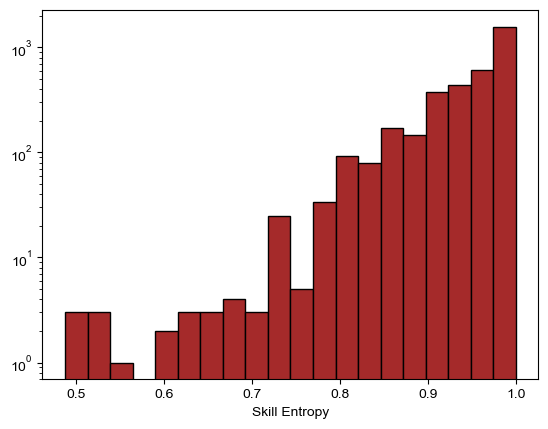

In [29]:
# Assign values from skills_data to partition 1 nodes
skill_data = df_skill.set_index('id')['skill_label'].to_dict()

for skill_name in skill_names:
    if skill_name in skill_data:
        value =  skill_data[skill_name]
        B.nodes[skill_name]['skill_category'] = value  # Add 'value' attribute to the node
        
# Calculate the overall unique job sectors
unique_skill_categories = set()
for skill_node in B.nodes(data=True):
    if skill_node[1]['bipartite'] == 1 and 'skill_category' in skill_node[1]:
        unique_skill_categories.add(skill_node[1]['skill_category'])

# Create a dictionary to store conditional probabilities of job sectors given skill neighbors
conditional_probs = {}

# Iterate through course nodes
for course_node in B.nodes(data=True):
    if course_node[1]['bipartite'] == 0:  # Check if it's a course node
        course_name = course_node[0]
        skill_neighbors = list(B.neighbors(course_name))

        if not skill_neighbors:
            continue  # Skip course nodes with no skill neighbors

        # Count the occurrence of each job sector in the neighbors
        skill_category_counts = {}
        for skill_neighbor in skill_neighbors:
            if 'skill_category' in B.nodes[skill_neighbor]:
                skill_category = B.nodes[skill_neighbor]['skill_category']
                skill_category_counts[skill_category] = skill_category_counts.get(skill_category, 0) + 1

        # Calculate conditional probabilities
        conditional_probs[course_name] = {skill_category: count / len(skill_neighbors) for skill_category, count in skill_category_counts.items()}

# Calculate entropy for each course node using scipy.stats.entropy
skill_entropy_values = {}
for course_name, conditional_probabilities in conditional_probs.items():
    prob_values = np.array(list(conditional_probabilities.values()))

    num_groups = len(conditional_probs[course_name])

    if num_groups >= 2:
       entropy_value = entropy(prob_values, base=num_groups)
    else:
       entropy_value = None  # Assign None for courses with no skill categories

    skill_entropy_values[course_name] = entropy_value

    # Create a histogram to visualize the distribution of entropy values
entropy_list = [value for value in skill_entropy_values.values() if value is not None]
plt.hist(entropy_list, bins=20, color='brown', edgecolor='black')
plt.xlabel('Skill Entropy')
plt.yscale('log')
plt.show()

In [30]:
for node in G.nodes(data=True):
    node_name = node[1]['name']  # Assuming 'name' is the attribute to match
    if node_name in skill_entropy_values:
        entropy_value = skill_entropy_values[node_name]
        G.nodes[node[0]]['skill_entropy_value'] = entropy_value

# Regression Analysis of Course Influence with Transferability and Skill Diversity

In [31]:
linear_data = []  # 리스트로 유지

for node in G.nodes():
    node_data = {
        'course_name': G.nodes[node]['name'],
        'coverage': G.nodes[node]['course_coverage'],
        'green_transferability': G.nodes[node]['green_transferability'],
        'digital_transferability': G.nodes[node]['digital_transferability'],
        'care_transferability': G.nodes[node]['care_transferability'],
        'i40_transferability': G.nodes[node]['i40_transferability'],
        'label': G.nodes[node]['label'],
        'skill_diversity': G.nodes[node].get('skill_entropy_value', None), 
        'degree': G.degree(node)
    }
    linear_data.append(node_data)  # 리스트에 추가

# Pandas DataFrame 생성
linear_df = pd.DataFrame(linear_data)
linear_df['course_influence'] = linear_df['coverage'] / linear_df['degree']
linear_df.head()

,course_name,coverage,green_transferability,digital_transferability,care_transferability,i40_transferability,label,skill_diversity,degree,course_influence
0,Certificate in Athlete Life Coaching,2.0,0,0,433,0,Sports,1.000000,80,0.025000
1,Continuous Improvement Management,14.0,0,0,1574,613,Productivity and Innovation,0.982337,282,0.049645
2,Design Transformative Learning and Development...,14.0,0,0,764,0,MICE & Events,0.933785,284,0.049296
3,People Development (Level 5),23.0,0,0,857,0,Leadership & People Management,0.934668,402,0.057214
4,Develop and Evaluate Strategies for Learning a...,23.0,0,0,1311,0,"Human Resource Management, Employment and Recr...",0.946211,345,0.066667


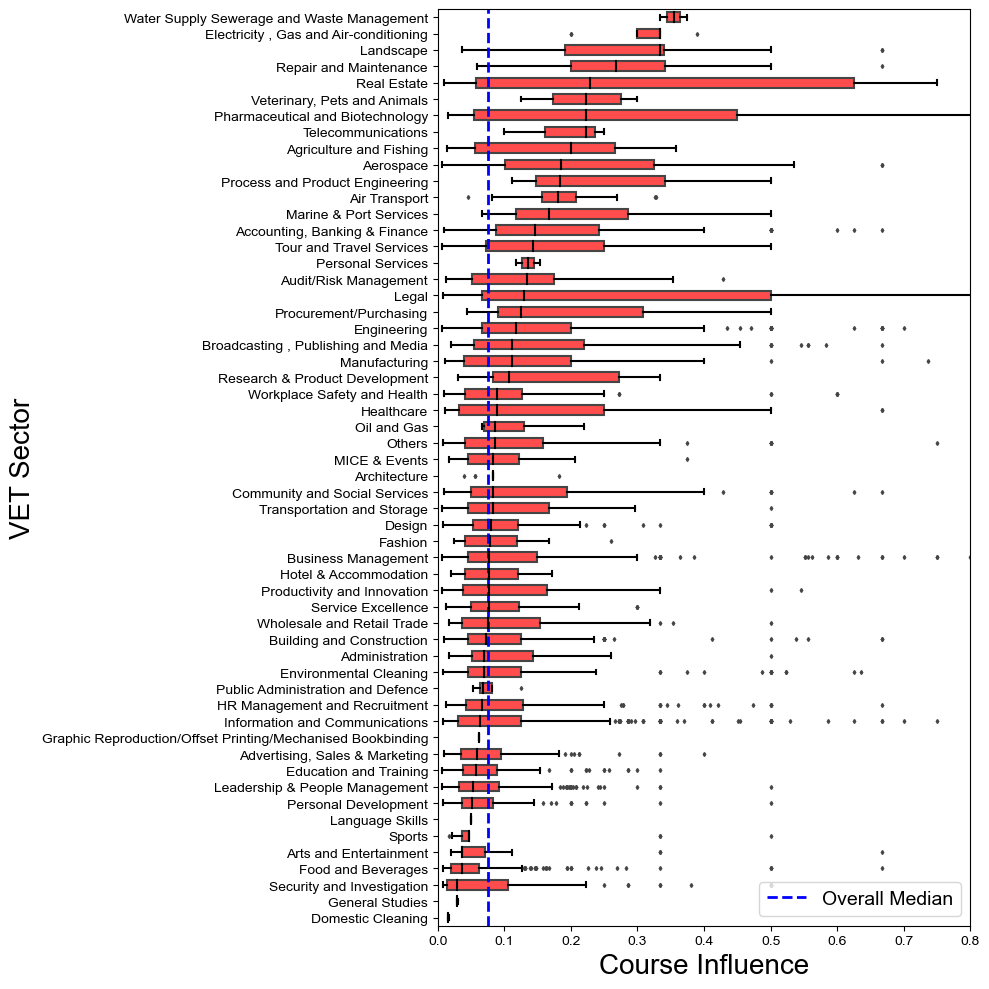

In [33]:
# Calculate the median course impact
median_course_impact = linear_df['course_influence'].median()

# Calculate the count for each sector
label_counts = linear_df['label'].value_counts()

# Filter labels with count below 50
filtered_labels = label_counts[label_counts >= 1].index

# Create a filtered DataFrame
filtered_df = linear_df[linear_df['label'].isin(filtered_labels)]

# Update the sector name
sector_to_update = "Human Resource Management, Employment and Recruitment"
new_sector_name = "HR Management and Recruitment"
filtered_df.loc[filtered_df['label'] == sector_to_update, 'label'] = new_sector_name

# Calculate the median for each sector and sort by it
median_values = filtered_df.groupby('label')['course_influence'].median().sort_values(ascending=False)
sorted_labels = median_values.index

# Plot the boxplot using seaborn
plt.figure(figsize=(10, 10))
box_plot = sns.boxplot(x='course_influence', y='label', data=filtered_df, order=sorted_labels, fliersize=2, width=0.6)

# Set the color and transparency for the boxes
box_color = (1, 0, 0, 0.7)  # Red with alpha 0.7
for patch in box_plot.artists:
    patch.set_facecolor(box_color)

# Set the color for the whiskers, caps, and fliers
line_color = 'black'
for line in box_plot.lines:
    line.set_color(line_color)

plt.xlabel('Course Influence', fontsize=20)
plt.ylabel('VET Sector', fontsize=20)  # Set y-label to VET Sector
plt.xticks(fontsize=10)  # Adjust x-tick label font size
plt.yticks(fontsize=10)  # Adjust y-tick label font size

# Limit the x-axis to the range 0 to 2.0
plt.xlim(0, 0.8)

# Add a vertical line for the overall median
plt.axvline(x=median_course_impact, color='blue', linestyle='--', linewidth=2, label='Overall Median')

plt.legend(loc='lower right', fontsize=14) 
plt.margins(x=0, y=0)
plt.tight_layout()
plt.savefig('Fig2_a.png', dpi=300)

plt.show()

In [34]:
# Regression Analysis of Course Influence Without Skill Diversity
regression_data = linear_df.copy()
regression_data.dropna(subset=['skill_diversity'], inplace=True)
regression_data['log_course_influence'] = np.log(regression_data['course_influence'])

scaler = MinMaxScaler()
columns_to_normalize = ['green_transferability', 'digital_transferability', 'care_transferability','i40_transferability']
regression_data [columns_to_normalize] = scaler.fit_transform(regression_data [columns_to_normalize])

# Fit the linear regression model with dummy variables for 'label'
model_1 = sm.OLS.from_formula('log_course_influence ~ green_transferability+digital_transferability+care_transferability+i40_transferability+skill_diversity+C(label)+1', regression_data).fit()
coeff_data = model_1.summary().tables[1].data
coeff_df = pd.DataFrame(coeff_data[1:], columns=coeff_data[0])
coeff_df.set_index(coeff_df.columns[0], inplace=True)

# 'C(label)' 관련 행 제거 후 복사본 생성
filtered_coeff_df = coeff_df[~coeff_df.index.str.contains('C\\(label\\)')].copy()

# 각 열의 숫자 값을 소수점 4자리까지 반올림 (문자열인 경우 float로 변환)
for col in filtered_coeff_df.columns:
    try:
        filtered_coeff_df.loc[:, col] = filtered_coeff_df[col].astype(float).round(4)
    except ValueError:
        # 변환이 불가능한 열은 건너뜁니다.
        pass

filtered_coeff_df

,coef,std err,t,P>|t|,[0.025,0.975]
,,,,,,
Intercept,1.4265,0.217,6.56,0.0,1.0,1.853
green_transferability,0.1836,0.207,0.888,0.374,-0.222,0.589
digital_transferability,-0.1338,0.131,-1.019,0.308,-0.391,0.124
care_transferability,-0.0573,0.134,-0.427,0.669,-0.32,0.206
i40_transferability,1.2592,0.153,8.215,0.0,0.959,1.56
skill_diversity,-3.6741,0.223,-16.452,0.0,-4.112,-3.236


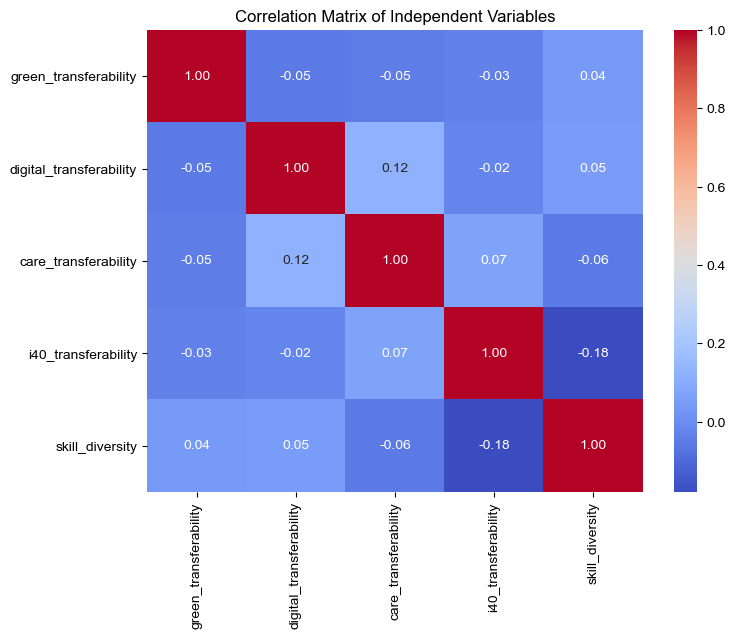

                   feature     VIF  1/VIF
0                    const  239.81   0.00
1    green_transferability    1.01   0.99
2  digital_transferability    1.02   0.98
3     care_transferability    1.02   0.98
4      i40_transferability    1.04   0.96
5          skill_diversity    1.04   0.96


In [35]:
# 회귀분석에 사용한 변수들 선택
features = ['green_transferability', 'digital_transferability', 'care_transferability', 'i40_transferability', 'skill_diversity']
X = regression_data[features]

# 변수 간 상관관계 행렬 계산 및 시각화
corr_matrix = X.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Independent Variables")
plt.show()

# VIF 분석을 위해 상수항 추가
X_const = sm.add_constant(X)

# VIF 계산
vif_data = pd.DataFrame({
    "feature": X_const.columns,
    "VIF": [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]
})
# 1/VIF 열 추가
vif_data["1/VIF"] = 1 / vif_data["VIF"]

# 1/VIF 열 추가 및 소수 둘째 자리로 반올림
vif_data["VIF"] = vif_data["VIF"].round(2)
vif_data["1/VIF"] = (1 / vif_data["VIF"]).round(2)
print(vif_data)

In [36]:
# Regression Analysis of Course Influence with Transferability and Skill Diversity
model_2 = sm.OLS.from_formula('log_course_influence ~ i40_transferability+skill_diversity+C(label)+1', regression_data).fit()
coeff_data = model_2.summary().tables[1].data
coeff_df = pd.DataFrame(coeff_data[1:], columns=coeff_data[0])
coeff_df.set_index(coeff_df.columns[0], inplace=True)

# 'C(label)' 관련 행 제거 후 복사본 생성
filtered_coeff_df = coeff_df[~coeff_df.index.str.contains('C\\(label\\)')].copy()

# 각 열의 숫자 값을 소수점 4자리까지 반올림 (문자열인 경우 float로 변환)
for col in filtered_coeff_df.columns:
    try:
        filtered_coeff_df.loc[:, col] = filtered_coeff_df[col].astype(float).round(4)
    except ValueError:
        # 변환이 불가능한 열은 건너뜁니다.
        pass

filtered_coeff_df

,coef,std err,t,P>|t|,[0.025,0.975]
,,,,,,
Intercept,1.4107,0.217,6.5,0.0,0.985,1.836
i40_transferability,1.2483,0.153,8.176,0.0,0.949,1.548
skill_diversity,-3.6627,0.223,-16.416,0.0,-4.1,-3.225


# Integration into a Unified Course-Job Network (T) Using Course-Skill and Skill-Job Networks


In [37]:
job_skill_matrix_df = pd.read_csv('/home/lhch9550/new_job_skill_matrix.csv')
job_skill_matrix_df.set_index('id', inplace=True)
job_skill_matrix_df

,ACC-AUD-4003-1.1,ACC-AUD-4001-1.1,ACC-PVE-3001-1.1,ACC-AUD-4004-1.1,ACC-AUD-4005-1.1,ACC-AUD-4006-1.1,ACC-AUD-4007-1.1,ACC-AUD-4008-1.1,ACC-MAC-3001-1.1,ACC-IAD-3001-1.1,...,WPH-QUA-5021-1.1,WPH-TEM-3017-1.1,WPH-TEM-3011-1.1,WPH-WSH-2079-1.1,WPH-WSH-2080-1.1,WPH-WSH-2081-1.1,WPH-WSH-2082-1.1,WPH-WSH-2083-1.1,WPH-WSH-1084-1.1,WPH-WSH-2085-1.1
id,,,,,,,,,,,,,,,,,,,,,
21491.BIO.01.002,0.373135,0.359174,0.248908,0.237445,0.456534,0.154524,0.484073,0.282735,0.306614,0.424757,...,0.308370,0.260727,0.608754,0.523127,0.529358,0.574667,0.513345,0.549038,0.363850,0.412238
11202.BIO.01.007,0.416023,0.458064,0.304043,0.374383,0.536807,0.350886,0.606649,0.312782,0.379850,0.636190,...,0.350575,0.305407,0.613512,0.608951,0.628944,0.632557,0.606527,0.625687,0.503821,0.424660
13291.BIO.01.006,0.423423,0.489452,0.323934,0.433761,0.603678,0.398844,0.637685,0.355141,0.409859,0.598005,...,0.340324,0.293641,0.543435,0.612426,0.641805,0.608198,0.607471,0.614481,0.493125,0.438517
81000.BIO.01.004,0.376965,0.390589,0.240751,0.317843,0.545138,0.253083,0.574203,0.358279,0.244836,0.517463,...,0.359905,0.272982,0.518840,0.579159,0.636075,0.613936,0.579141,0.606108,0.491537,0.459836
21491.BIO.01.004,0.381180,0.385020,0.243417,0.313355,0.493377,0.207807,0.551421,0.368699,0.292125,0.466192,...,0.291997,0.268563,0.589097,0.557602,0.574672,0.606568,0.555962,0.575087,0.397458,0.430881
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24131.FIN.02.001,0.434579,0.431476,0.295834,0.415195,0.388482,0.319924,0.356100,0.370322,0.535837,0.550592,...,0.233389,0.131422,0.414043,0.357355,0.298679,0.347077,0.318964,0.341364,0.263248,0.160445
24132.FIN.02.002,0.515959,0.520360,0.541457,0.425128,0.661816,0.333573,0.607845,0.420747,0.308635,0.533068,...,0.480941,0.121640,0.241100,0.675223,0.626385,0.643244,0.612734,0.665383,0.512778,0.338479
24141.FIN.01.001,0.447522,0.478996,0.357705,0.360099,0.545466,0.287090,0.465342,0.273232,0.489234,0.518248,...,0.268339,0.217104,0.421952,0.417785,0.335665,0.411823,0.383812,0.418398,0.311539,0.155523


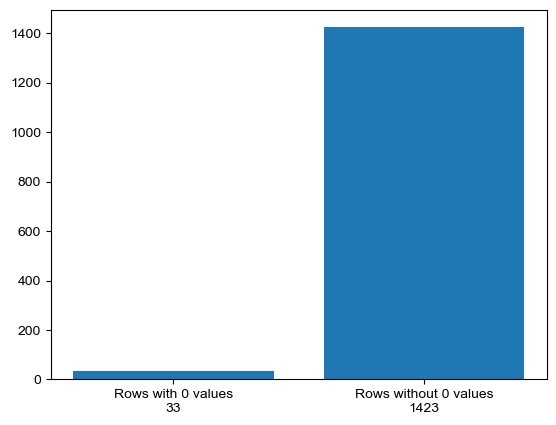

In [38]:
job_skill_matrix = job_skill_matrix_df.values
threshold = 0.6

filtered_matrix_2 = np.where(job_skill_matrix < threshold, 0, job_skill_matrix)

# Replace non-zero values with 1
filtered_matrix_2[filtered_matrix_2 != 0] = 1

# Count rows with at least one "1"
row_counts = np.sum(filtered_matrix_2, axis=1) > 0
rows_with_ones = np.sum(row_counts)

# Calculate the number of rows with 0 and 1
rows_with_zeros = filtered_matrix_2.shape[0] - rows_with_ones

# Create a bar chart to visualize the comparison
labels = ['Rows with 0 values\n{}'.format(rows_with_zeros), 'Rows without 0 values\n{}'.format(rows_with_ones)]
values = [rows_with_zeros, rows_with_ones]

plt.bar(labels, values)
plt.show()

In [39]:
#to calcualte course specificity, start with making a bipartite network of course-job/skill
S = nx.Graph()

job_names = job_skill_matrix_df.index
skill_names = job_skill_matrix_df.columns

S.add_nodes_from(job_names, bipartite=0) 
S.add_nodes_from(skill_names, bipartite=1)   

for i in range(len(job_names)):
    job_name = job_names[i]
    for j in range(len(skill_names)):
        value = filtered_matrix_2[i, j]
        if value == 1:
            skill_name = skill_names[j]
            S.add_edge(job_name, skill_name)

In [40]:
#to calcualte course specificity, start with making a bipartite network of course-job/skill
S = nx.Graph()

job_names = job_skill_matrix_df.index
skill_names = job_skill_matrix_df.columns

S.add_nodes_from(job_names, bipartite=0) 
S.add_nodes_from(skill_names, bipartite=1)   

for i in range(len(job_names)):
    job_name = job_names[i]
    for j in range(len(skill_names)):
        value = filtered_matrix_2[i, j]
        if value == 1:
            skill_name = skill_names[j]
            S.add_edge(job_name, skill_name)

In [41]:
# Combine the Course-Skill network (B) and the Skill-Job network (S) into a unified network (T)
# - B represents the connections between courses and skills.
# - S represents the connections between skills and jobs.
T = nx.compose(B, S)

In [42]:
# Extract edge lists
course_skill_edges = [(source, target) for source, target in T.edges() if source in course_names and target in skill_names]
skill_job_edges = [(source, target) for source, target in T.edges() if source in skill_names and target in job_names]

# Create DataFrames for each edge list
course_skill_edgelist = pd.DataFrame(course_skill_edges, columns=['Course', 'Skill'])
skill_job_edgeslist = pd.DataFrame(skill_job_edges, columns=['Skill', 'Job'])
course_job_edgeslist = pd.merge(course_skill_edgelist, skill_job_edgeslist, on='Skill',how='left')

In [43]:
# Combine the course-skill and skill-job edge lists to create a course-job edge list.
# - The `course_skill_edgelist` contains edges between courses and skills.
# - The `skill_job_edgeslist` contains edges between skills and jobs.
course_job_edgeslist

,Course,Skill,Job
0,Certificate in Athlete Life Coaching,ECM-LDM-4004-1.1,13420.HEA.02.009
1,Certificate in Athlete Life Coaching,ECM-LDM-4004-1.1,22200.HEA.03.007
2,Certificate in Athlete Life Coaching,ECM-LDM-4004-1.1,22200.HEA.06.008
3,Certificate in Athlete Life Coaching,ECM-LDM-4004-1.1,22680.HEA.03.003
4,Certificate in Athlete Life Coaching,ECM-LDM-4004-1.1,22680.HEA.06.002
...,...,...,...
2431341,Conflict Management,SSC-PDV-2008-1.1-1,34110.LEG.08.005
2431342,Conflict Management,SSC-PDV-2008-1.1-1,12121.HRM.07.003
2431343,Conflict Management,SSC-PDV-2008-1.1-1,12121.HRM.03.003
2431344,Conflict Management,SSC-PDV-2008-1.1-1,96211.HAS.01.006


In [44]:
# Try reading the CSV file with different encodings
encodings_to_try = ['utf-8', 'ISO-8859-1', 'utf-16']

for encoding in encodings_to_try:
    try:
        salary_df = pd.read_csv('df_job_salary.csv', encoding=encoding)
        break  # If successful, exit the loop
    except UnicodeDecodeError:
        continue  # If not successful, try the next encoding

#salary_df['average_salary'] = salary_df[['min_salary', 'max_salary']].mean(axis=1)
salary_df = pd.merge(course_job_edgeslist, salary_df,left_on='Job',right_on='job_code',how='left')
salary_df = salary_df.groupby('Course')['max_salary'].median().reset_index()
salary_df

,Course,max_salary
0,Building Information Modelling (BIM) for Secu...,6000.0
1,Business Opportunities Development,8000.0
2,Counselling and Communication,5420.0
3,Effective Supervisory Skills,6400.0
4,Excel In Data Analysis,7507.0
...,...,...
5441,goDCE (Distribution Centre Excellence),6000.0
5442,goIP - Smart Cloud Inventory Solution (Classro...,3600.0
5443,goRPA -UIPath,4985.0
5444,iAdvance Digital Capabilities with Apple Techn...,6300.0


In [47]:
regression_data_salary = pd.merge(linear_df, salary_df,left_on='course_name',right_on='Course',how='left')
regression_data_salary = regression_data_salary.dropna(subset=['max_salary'])
regression_data_salary['log_max_salary'] = np.log(regression_data_salary['max_salary'])
regression_data_salary['log_course_influence'] = np.log(regression_data_salary['course_influence'])

scaler = MinMaxScaler()
columns_to_normalize = ['green_transferability', 'digital_transferability', 'care_transferability','i40_transferability']
regression_data_salary[columns_to_normalize] = scaler.fit_transform(regression_data_salary[columns_to_normalize])

# Regression Analysis of Course Influence with Transferability and Skill Diversity
model_3 = sm.OLS.from_formula('log_course_influence ~ green_transferability+digital_transferability+care_transferability+i40_transferability+C(label)+log_max_salary+1', regression_data_salary).fit()
coeff_data = model_3.summary().tables[1].data
coeff_df = pd.DataFrame(coeff_data[1:], columns=coeff_data[0])
coeff_df.set_index(coeff_df.columns[0], inplace=True)

# 'C(label)' 관련 행 제거 후 복사본 생성
filtered_coeff_df = coeff_df[~coeff_df.index.str.contains('C\\(label\\)')].copy()

# 각 열의 숫자 값을 소수점 4자리까지 반올림 (문자열인 경우 float로 변환)
for col in filtered_coeff_df.columns:
    try:
        filtered_coeff_df.loc[:, col] = filtered_coeff_df[col].astype(float).round(4)
    except ValueError:
        # 변환이 불가능한 열은 건너뜁니다.
        pass

filtered_coeff_df

,coef,std err,t,P>|t|,[0.025,0.975]
,,,,,,
Intercept,-3.1383,0.399,-7.861,0.0,-3.921,-2.356
green_transferability,0.1358,0.241,0.564,0.573,-0.336,0.608
digital_transferability,-0.019,0.146,-0.13,0.897,-0.305,0.267
care_transferability,0.0522,0.152,0.344,0.731,-0.245,0.349
i40_transferability,1.8807,0.169,11.116,0.0,1.549,2.212
log_max_salary,0.1262,0.043,2.937,0.003,0.042,0.21


In [48]:
# Regression Analysis of Course Influence with Transferability and Skill Diversity
model_4 = sm.OLS.from_formula('log_course_influence ~ green_transferability+digital_transferability+care_transferability+i40_transferability+log_max_salary+skill_diversity+1', regression_data_salary).fit()
coeff_data = model_4.summary().tables[1].data
coeff_df = pd.DataFrame(coeff_data[1:], columns=coeff_data[0])
coeff_df.set_index(coeff_df.columns[0], inplace=True)

# 'C(label)' 관련 행 제거 후 복사본 생성
filtered_coeff_df = coeff_df[~coeff_df.index.str.contains('C\\(label\\)')].copy()

# 각 열의 숫자 값을 소수점 4자리까지 반올림 (문자열인 경우 float로 변환)
for col in filtered_coeff_df.columns:
    try:
        filtered_coeff_df.loc[:, col] = filtered_coeff_df[col].astype(float).round(4)
    except ValueError:
        # 변환이 불가능한 열은 건너뜁니다.
        pass

filtered_coeff_df

,coef,std err,t,P>|t|,[0.025,0.975]
,,,,,,
Intercept,0.4831,0.442,1.094,0.274,-0.383,1.349
green_transferability,0.2726,0.215,1.269,0.205,-0.149,0.694
digital_transferability,-0.1217,0.124,-0.983,0.326,-0.365,0.121
care_transferability,-0.3439,0.128,-2.689,0.007,-0.595,-0.093
i40_transferability,1.4259,0.152,9.384,0.0,1.128,1.724
log_max_salary,0.0833,0.042,1.997,0.046,0.002,0.165
skill_diversity,-3.9432,0.221,-17.836,0.0,-4.377,-3.51


# Oversupply Index Analysis for Course-Job Connections by Sector

In [49]:
# Group course-job connections by 'Job' and count unique courses
course_job_counts = course_job_edgeslist.groupby('Job')['Course'].nunique().reset_index()
# 'id' represents the Job ID, and 'No.Jobs' indicates the count of unique courses linked to each job
course_job_counts.columns = ['id', 'No.Jobs']
course_job_counts = pd.merge(course_job_counts, df_job, on='id', how='left')
course_job_counts

,id,No.Jobs,job_label,tokenized_sentences,sector_label
0,11201.ACC.01.005,711,Financial Accounting/Management Accounting,['A Chief Financial Officer heads the finance ...,Accountancy
1,11201.AER.01.009,1004,Aircraft Engine / Component Maintenance,['A General Manager in Aircraft Engine and Com...,Aerospace
2,11201.AER.02.009,969,Aircraft Maintenance,['A General Manager in Aircraft Maintenance is...,Aerospace
3,11201.AER.03.009,1082,Manufacturing,['A General Manager in Manufacturing plans and...,Aerospace
4,11201.BIO.01.002,1206,General Management,['The Site Director steers the manufacturing p...,Biopharmaceuticals Manufacturing
...,...,...,...,...,...
1409,96211.HAS.01.004,156,Front Office,"[""A Concierge is the contact person for guests...",Hotel and Accommodation Services
1410,96211.HAS.01.005,978,Front Office,"[""Supporting the Chef Concierge or Front Offic...",Hotel and Accommodation Services
1411,96211.HAS.01.006,1037,Front Office,['A Chef Concierge oversees all aspects of the...,Hotel and Accommodation Services
1412,96212.HAS.01.001,3,Front Office,['Usually the first to welcome arriving guests...,Hotel and Accommodation Services


In [50]:
# Step 1: Calculate overall average number of jobs
overall_avg = course_job_counts['No.Jobs'].mean()

# Step 2: Calculate oversupply index for each sector
course_job_counts['OCS Index'] = course_job_counts['No.Jobs'] / overall_avg
course_job_counts

,id,No.Jobs,job_label,tokenized_sentences,sector_label,OCS Index
0,11201.ACC.01.005,711,Financial Accounting/Management Accounting,['A Chief Financial Officer heads the finance ...,Accountancy,1.548106
1,11201.AER.01.009,1004,Aircraft Engine / Component Maintenance,['A General Manager in Aircraft Engine and Com...,Aerospace,2.186074
2,11201.AER.02.009,969,Aircraft Maintenance,['A General Manager in Aircraft Maintenance is...,Aerospace,2.109866
3,11201.AER.03.009,1082,Manufacturing,['A General Manager in Manufacturing plans and...,Aerospace,2.355908
4,11201.BIO.01.002,1206,General Management,['The Site Director steers the manufacturing p...,Biopharmaceuticals Manufacturing,2.625901
...,...,...,...,...,...,...
1409,96211.HAS.01.004,156,Front Office,"[""A Concierge is the contact person for guests...",Hotel and Accommodation Services,0.339669
1410,96211.HAS.01.005,978,Front Office,"[""Supporting the Chef Concierge or Front Offic...",Hotel and Accommodation Services,2.129462
1411,96211.HAS.01.006,1037,Front Office,['A Chef Concierge oversees all aspects of the...,Hotel and Accommodation Services,2.257927
1412,96212.HAS.01.001,3,Front Office,['Usually the first to welcome arriving guests...,Hotel and Accommodation Services,0.006532


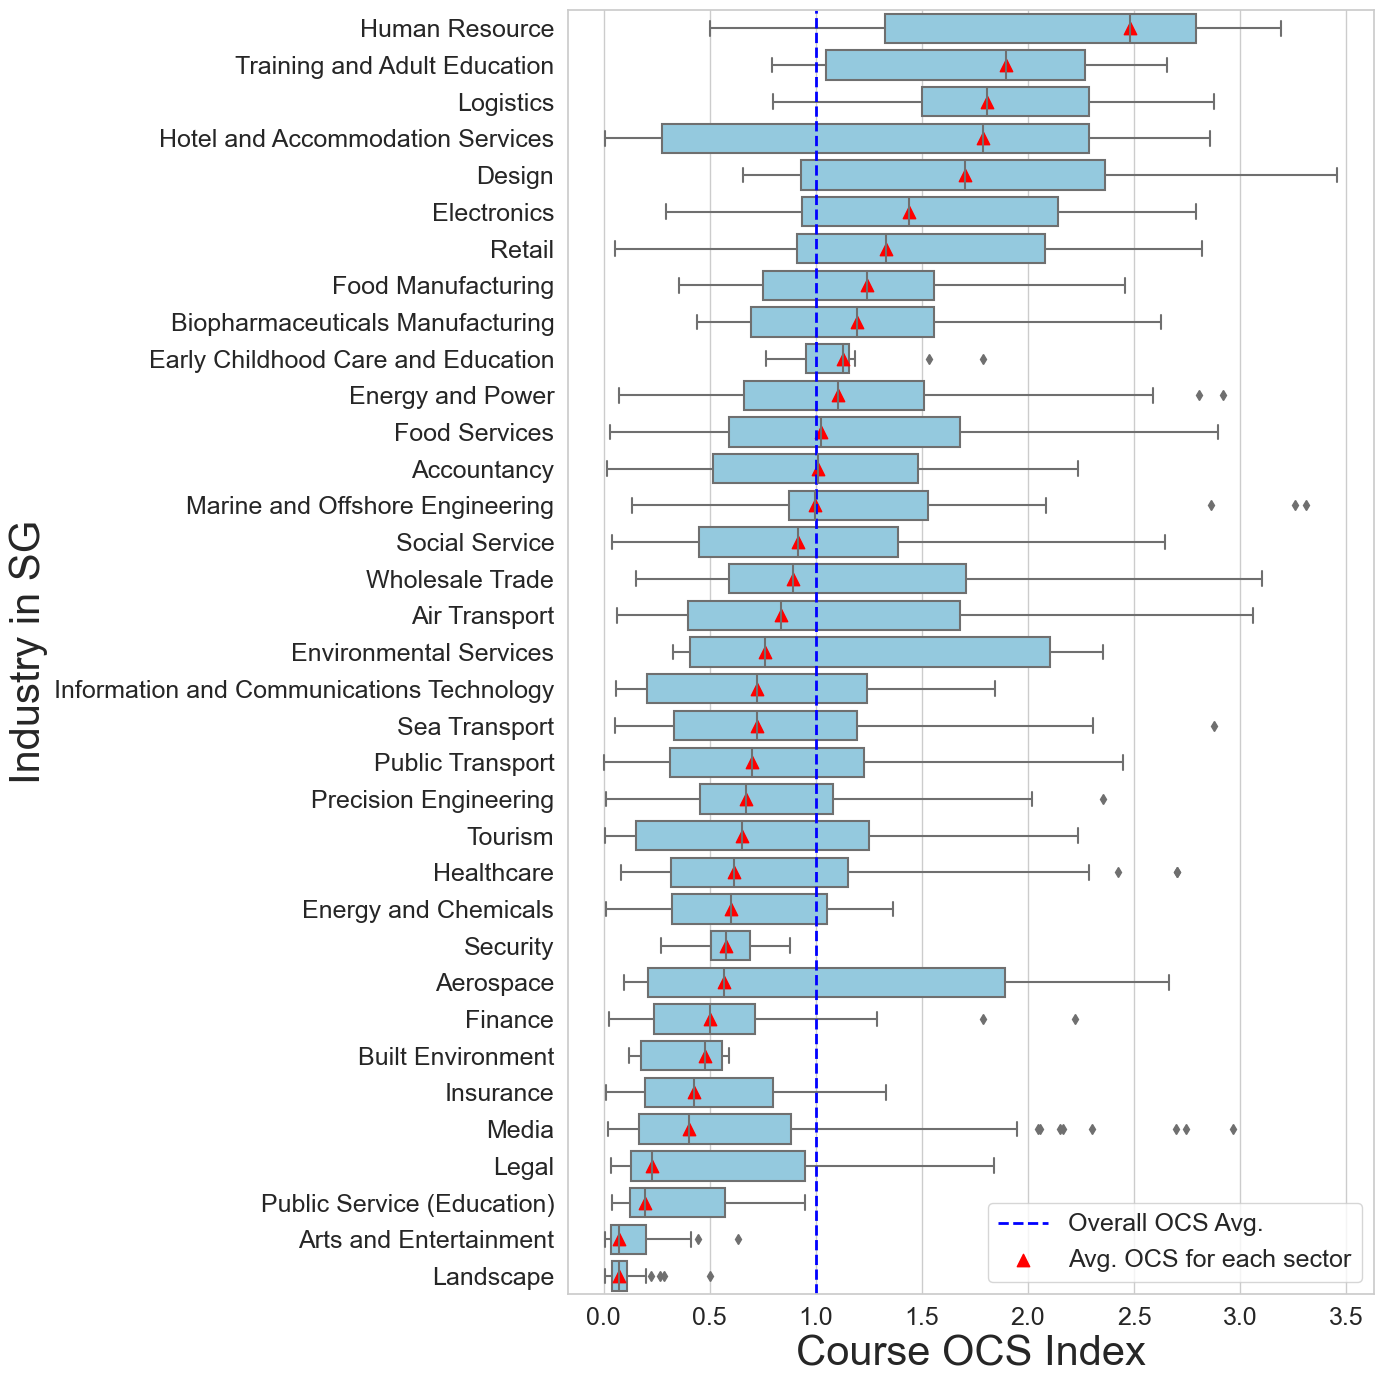

In [51]:
# Calculate average 'Oversupply Index' for each 'sector_label'
average_oversupply = course_job_counts.groupby('sector_label')['OCS Index'].median().reset_index()

# Sort the DataFrame based on the average 'Oversupply Index' in descending order
sorted_df = average_oversupply.sort_values(by='OCS Index', ascending=False)

# Replace 'your_data' and 'your_target_variable' with your actual data and target variable
sns.set(style="whitegrid")
plt.figure(figsize=(14, 14))

# Use boxplot to show the distribution of 'Oversupply Index' for each 'sector_label'
boxplot = sns.boxplot(x="OCS Index", y="sector_label", data=course_job_counts, order=sorted_df['sector_label'], orient="h", color='skyblue')  # Set color to 'skyblue'

# Add triangles for the average values
for i, value in enumerate(sorted_df['OCS Index']):
    plt.scatter(value, i, color='red', marker='^', s=80, label='Avg. OCS for each sector' if i == 0 else '')

# Set labels and title
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel("Course OCS Index", fontsize=30)
plt.ylabel("Industry in SG", fontsize=30)

# Add a vertical line for overall oversupply average
boxplot.axvline(x=1, color='blue', linestyle='--', linewidth=2, label='Overall OCS Avg.')

# Add legend
plt.legend(fontsize=18)

plt.tight_layout()
plt.savefig('Fig4_a.png', bbox_inches='tight', dpi=300)

plt.show()

# Extracting Transferability Metrics and Analyzing Correlation with Oversupply Index

In [52]:
df_skill_original = pd.read_csv('df_skill_original.csv')

def process_csv(csv_filename, transferability_category, network_name):
    # Read CSV file
    skill_data = pd.read_csv(csv_filename)
    # Rename columns if necessary
    skill_data = skill_data.rename(columns={'Title of Priority Skill': 'TSC_CCS Title', 'Description of Priority Skill': 'TSC_CCS Description'})
    # Merge with original skill data
    skill_data = pd.merge(skill_data, df_skill_original, on=['TSC_CCS Title', 'TSC_CCS Description'], how='left')
    # Drop rows with missing values
    skill_data = skill_data.dropna()
    # Select relevant columns
    skill_data = skill_data[['TSC_CCS Code', 'TSC_CCS Title', 'TSC_CCS Description', 'Transferability']]
    # Create a dictionary from the DataFrame
    skills_transferability = skill_data.set_index('TSC_CCS Code')['Transferability'].to_dict()

    # Assign values to the network nodes
    for skill_name in skill_names:
        if skill_name in skills_transferability:
            value = skills_transferability[skill_name]
            S.nodes[skill_name][f'{transferability_category}_transferability'] = value

    for job_name in job_names:
        # Find neighbors of job_name node
        neighbors = list(S.neighbors(job_name))

        # Sum the total transferability value from neighbor skill nodes
        total_transferability = 0
        for neighbor in neighbors:
            if f'{transferability_category}_transferability' in S.nodes[neighbor]:
                total_transferability += S.nodes[neighbor][f'{transferability_category}_transferability']
        # Assign the total transferability value to the job node
        S.nodes[job_name][f'total_{transferability_category}_transferability'] = total_transferability

In [53]:
process_csv('Care Economy.csv', 'care', 'S')
process_csv('Green Economy.csv', 'green', 'S')
process_csv('Digital Economy.csv', 'digital', 'S')
process_csv('I4.0 Economy.csv', 'i40', 'S')

In [54]:
labels_skill = {node: row['skill_label'] for node, row in df_skill.set_index('id').iterrows()}
labels_job = {node: row['job_label'] for node, row in df_job.set_index('id').iterrows()}

for node in S.nodes():
    if S.nodes[node]['bipartite'] == 0:
        S.nodes[node]['job_label'] = labels_job.get(node)
    elif S.nodes[node]['bipartite'] == 1:
        S.nodes[node]['skill_label'] = labels_skill.get(node) 

sector_data = df_job.set_index('id')['sector_label'].to_dict()

for job_name in job_names:
    if job_name in sector_data:
        value = sector_data[job_name]
        S.nodes[job_name]['sector_label'] = value  # Use 'industry' consistently

In [58]:
job_projection = nx.bipartite.projected_graph(S, job_names)

transferability_types = ['total_care_transferability', 'total_green_transferability', 'total_i40_transferability', 'total_digital_transferability']

# Initialize a dictionary to store results for each transferability type
transferability_results = {}

# Iterate over each transferability type
for transferability_type in transferability_types:
    sector_transferability = {}

    # Traverse through each job in the bipartite network
    for job_name in job_names:
        sector_label = S.nodes[job_name]['sector_label']
        transferability = S.nodes[job_name][transferability_type]

        # Update the dictionary with cumulative transferability and count
        if sector_label not in sector_transferability:
            sector_transferability[sector_label] = {'sum_transferability': 0, 'count': 0}
        sector_transferability[sector_label]['sum_transferability'] += transferability
        sector_transferability[sector_label]['count'] += 1

    # Calculate median transferability for each sector_label
    median_transferability = {}
    for sector_label, values in sector_transferability.items():
        transferability_values = [S.nodes[job_name][transferability_type] for job_name in job_names if S.nodes[job_name]['sector_label'] == sector_label]
        median_transferability[sector_label] = np.median(transferability_values)

    # Store the results in the dictionary
    transferability_results[transferability_type] = pd.DataFrame(list(median_transferability.items()), columns=['sector_label', f'median_{transferability_type}'])

# Merge the results into a single DataFrame
final_result = pd.DataFrame({'sector_label': transferability_results['total_care_transferability']['sector_label']})
for transferability_type in transferability_types:
    final_result = pd.merge(final_result, transferability_results[transferability_type], on='sector_label')

coursesupply_transferability = pd.merge(average_oversupply, final_result, on='sector_label', how='left')
coursesupply_transferability.head()

,sector_label,OCS Index,median_total_care_transferability,median_total_green_transferability,median_total_i40_transferability,median_total_digital_transferability
0,Accountancy,1.008120,1063.0,0.0,669.0,931.0
1,Aerospace,0.567203,0.0,0.0,1973.5,43.0
2,Air Transport,0.835019,30.0,0.0,398.0,271.0
3,Arts and Entertainment,0.074030,0.0,0.0,0.0,0.0
4,Biopharmaceuticals Manufacturing,1.195373,188.0,0.0,5057.0,1880.0


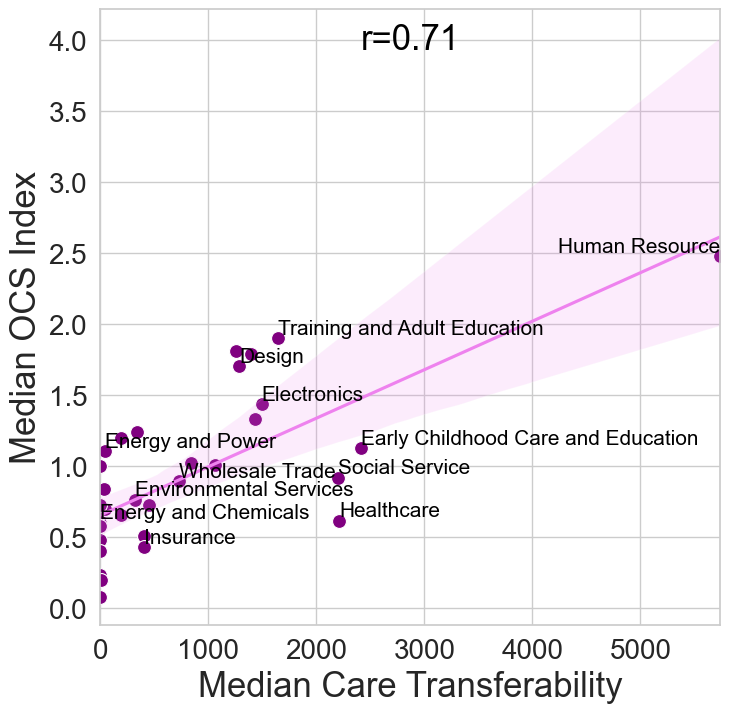

In [59]:
# Create a scatter plot
plt.figure(figsize=(8, 8))
sns.scatterplot(x='median_total_care_transferability', y='OCS Index', 
                data=coursesupply_transferability, color='purple', s=100)

# Draw a fitted regression line (regression line)
sns.regplot(x='median_total_care_transferability', y='OCS Index', 
            data=coursesupply_transferability, scatter=False, color='violet')

# Calculate the correlation coefficient
correlation_coefficient = coursesupply_transferability['median_total_care_transferability'].corr(
    coursesupply_transferability['OCS Index']
)

# Define the allowed labels to annotate
allowed_labels = {
    "Human Resource",
    "Training and Adult Education",
    "Social Service",
    "Early Childhood Care and Education",
    "Energy and Power",
    "Energy and Chemicals",
    "Electronics",
    "Design",
    "Insurance",
    "Healthcare",
    "Environmental Services",
    "Wholesale Trade"
}

# Annotate only the allowed labels
for label, x, y in zip(coursesupply_transferability['sector_label'], 
                       coursesupply_transferability['median_total_care_transferability'], 
                       coursesupply_transferability['OCS Index']):
    if label in allowed_labels:
        # Modify labels for display if necessary
        if label == "Information and Communications Technology":
            display_label = "Information&Communications"
        elif label == "Marine and Offshore Engineering":
            display_label = "Marine Engineering"
        elif label == "Hotel and Accommodation Services":
            display_label = "Hotel and Accomodation"
        else:
            display_label = label
            
    if label in allowed_labels:
        # For "Human Resource", align text to the right; for all others, align left.
        ha_value = 'right' if label == 'Human Resource' else 'left'
        plt.text(x, y, label, fontsize=15, ha=ha_value, va='bottom', color='black')

# Annotate the plot with the correlation coefficient
plt.annotate(f'r={correlation_coefficient:.2f}',
             xy=(0.5, 0.95), xycoords='axes fraction',
             ha='center', va='center', fontsize=25, color='black')

# Set axis labels and ticks
plt.xlabel('Median Care Transferability', fontsize=25)
plt.ylabel('Median OCS Index', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.savefig('Fig4_c.png',dpi=300)

plt.show()

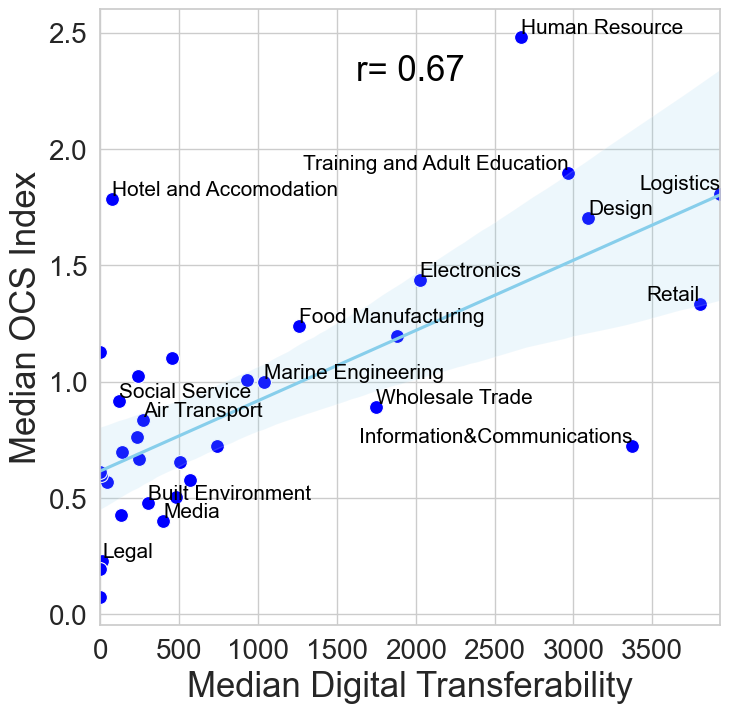

In [60]:
# Create a scatter plot
plt.figure(figsize=(8, 8))
sns.scatterplot(x='median_total_digital_transferability', y='OCS Index',
                data=coursesupply_transferability, color='blue', s=100)

# Draw a fitted regression line
sns.regplot(x='median_total_digital_transferability', y='OCS Index',
            data=coursesupply_transferability, scatter=False, color='skyblue')

# Calculate the correlation coefficient
correlation_coefficient = coursesupply_transferability['median_total_digital_transferability'].corr(
    coursesupply_transferability['OCS Index']
)

# Define the allowed sector labels to annotate
allowed_labels = {
    "Human Resource",
    "Training and Adult Education",
    "Logistics",
    "Design",
    "Retail",
    "Electronics",
    "Hotel and Accommodation Services",
    "Food Manufacturing",
    "Wholesale Trade",
    "Information and Communications Technology",
    "Marine and Offshore Engineering",
    "Media",
    "Legal",
    "Social Service",
    "Built Environment",
    "Air Transport"
}

# Annotate only the allowed labels with custom horizontal alignment.
for label, x, y in zip(coursesupply_transferability['sector_label'],
                       coursesupply_transferability['median_total_digital_transferability'],
                       coursesupply_transferability['OCS Index']):
    if label in allowed_labels:
        # Modify labels for display if necessary
        if label == "Information and Communications Technology":
            display_label = "Information&Communications"
        elif label == "Marine and Offshore Engineering":
            display_label = "Marine Engineering"
        elif label == "Hotel and Accommodation Services":
            display_label = "Hotel and Accomodation"
        else:
            display_label = label

        # Set custom horizontal alignment for specific labels
        if label in ['Training and Adult Education', 'Information and Communications Technology', 'Logistics','Retail']:
            ha_value = 'right'
        else:
            ha_value = 'left'
            
        plt.text(x, y, display_label, fontsize=15, ha=ha_value, va='bottom', color='black')

# Annotate the plot with the correlation coefficient
plt.annotate(f'r= {correlation_coefficient:.2f}',
             xy=(0.5, 0.90), xycoords='axes fraction',
             ha='center', va='center', fontsize=25, color='black')

# Set axis labels and tick parameters
plt.xlabel('Median Digital Transferability', fontsize=25)
plt.ylabel('Median OCS Index', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.savefig('Fig4_d.png',dpi=300)

plt.show()

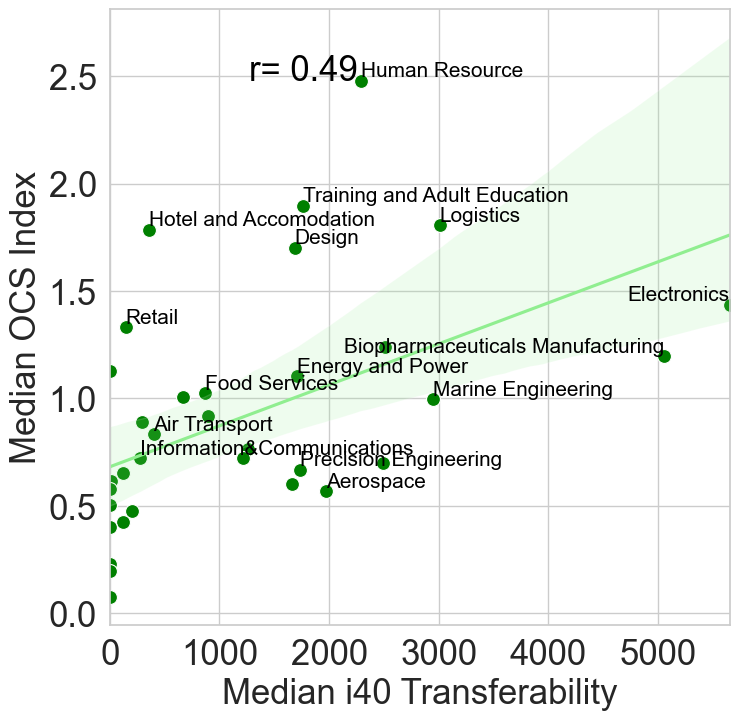

In [61]:
# Create a scatter plot
plt.figure(figsize=(8, 8))
sns.scatterplot(x='median_total_i40_transferability', y='OCS Index',
                data=coursesupply_transferability, color='green', s=100)

# Draw a fitted regression line
sns.regplot(x='median_total_i40_transferability', y='OCS Index',
            data=coursesupply_transferability, scatter=False, color='lightgreen')

# Calculate the correlation coefficient
correlation_coefficient = coursesupply_transferability['median_total_i40_transferability'].corr(
    coursesupply_transferability['OCS Index']
)

# Define the allowed sector labels to annotate
allowed_labels = {
    "Human Resource",
    "Training and Adult Education",
    "Electronics",
    "Marine and Offshore Engineering",
    "Hotel and Accommodation Services",
    "Design",
    "Biopharmaceuticals Manufacturing",
    "Air Transport",
    "Retail",
    "Aerospace",
    "Environmental Service",
    "Energy and Power",
    "Information and Communications Technology",
    "Logistics",
    "Food Services",
    "Precision Engineering"
}

# Annotate only the allowed labels with custom horizontal alignment and modified display names
for label, x, y in zip(coursesupply_transferability['sector_label'],
                       coursesupply_transferability['median_total_i40_transferability'],
                       coursesupply_transferability['OCS Index']):
    if label in allowed_labels:
        # Modify labels for display if necessary
        if label == "Information and Communications Technology":
            display_label = "Information&Communications"
        elif label == "Marine and Offshore Engineering":
            display_label = "Marine Engineering"
        elif label == "Hotel and Accommodation Services":
            display_label = "Hotel and Accomodation"
        else:
            display_label = label

        # Set custom horizontal alignment: for 'Electronics' and 'Biopharmaceuticals Manufacturing', use right; others use left.
        ha_value = 'right' if label in ['Electronics', 'Biopharmaceuticals Manufacturing'] else 'left'
        plt.text(x, y, display_label, fontsize=15, ha=ha_value, va='bottom', color='black')

# Annotate the plot with the correlation coefficient
plt.annotate(f'r= {correlation_coefficient:.2f}',
             xy=(0.4, 0.90), xycoords='axes fraction',
             ha='right', va='center', fontsize=25, color='black')

# Set axis labels and tick parameters
plt.xlabel('Median i40 Transferability', fontsize=25)
plt.ylabel('Median OCS Index', fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

plt.savefig('Fig4_e.png',dpi=300)

plt.show()